In [209]:
import numpy as np
import pandas as pd
import time
from scipy.cluster.hierarchy import dendrogram
from itertools import combinations

from sklearn.cluster import DBSCAN, AgglomerativeClustering, AffinityPropagation, KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from scipy.spatial.distance import pdist,cdist
import hdbscan
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
import umap

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_color_codes()

plot_kwds = {'alpha':0.5, 's':100, 'linewidth':0}
markers = ['o','v','^','<','>','s','*','D']

In [ ]:
dataName = 'allHV.npz'
emgHVType =  'hvRel'
allHV = np.load(dataName)
hv = allHV[emgHVType]
gestLabel = allHV['gestLabel']
posLabel = allHV['posLabel']
trialLabel = allHV['trialLabel']

gestures = np.unique(gestLabel)
positions = np.unique(posLabel)
trials = np.unique(trialLabel)

numGestures = len(gestures)
numPositions = len(positions)
numTrials = len(trials)

D = hv.shape[1]
numHV = 80

gPalette = sns.color_palette('Paired', numGestures)
pPalette = sns.color_palette('Paired', numPositions)

In [ ]:
proj = np.load('./projections/projAll.npy')
projG = []
for g in gestures:
    projG.append(np.load('./projections/projG' + str(g) + '.npy'))
projP = []
for p in positions:
    projP.append(np.load('./projections/projP' + str(p) + '.npy'))
projGP = []
for g in gestures:
    temp = []
    for p in positions:
        temp.append(np.load('./projections/projG' + str(g) + 'P' + str(p) + '.npy'))
    projGP.append(temp)
projGPT = []
for g in gestures:
    temp1 = []
    for p in positions:
        temp2 = []
        for t in trials:
            temp2.append(np.load('./projections/projG' + str(g) + 'P' + str(p) + 'T' + str(t) + '.npy'))
        temp1.append(temp2)
    projGPT.append(temp1)

# Gesture cluster analysis

## Clustering analysis within each gesture class
- Perform (mostly) unsupervised clustering to split each gesture class into multiple subclusters
- Focus on methods that look for globular, prototype-based clusters (agglomerative hierachical clustering with Ward's method, K-means/mediods, etc.)
- For now, it is okay to split things up too finely, since we can prune clusters later on based on classification performance

## Unsupervised clustering metrics

### Basic statistics

- Number of clusters
- Number of outliers (noise or unclustered points)

### Graph-based view of cohesion and separation
Graph-based cohesion (`graphCo`): sum of distances between all pairs of points within cluster, **want to minimize**

\begin{equation*}
cohesion\left(C_i\right) = \sum\limits_{x \in C_i, y \in C_i}dist(x,y)
\end{equation*}

Graph-based separation (`graphSep`): sum of distances between all pairs of points between two clusters, **want to maximize**

\begin{equation*}
separation\left(C_i, C_j\right) = \sum\limits_{x \in C_i, y \in C_j}dist(x,y)
\end{equation*}

### Prototype-based view of cohesion and separation
Prototype-based cohesion (`protoCo`): sum of distances between points within cluster and cluster prototype, **want to minimize**

\begin{equation*}
cohesion\left(C_i\right) = \sum\limits_{x \in C_i}dist(x,c_i)
\end{equation*}

Prototype-based separation of a single cluster (`protoSepSingle`): distance between cluster prototype and global prototype, **want to maximize**

\begin{equation*}
separation\left(C_i, C_j\right) = dist(c_i,c_j)
\end{equation*}

Prototype-based separation between clusters (`protoSepPair`): distance between cluster prototypes, **want to maximize**

\begin{equation*}
separation\left(C_i\right) = dist(c_i,c)
\end{equation*}

### Overall measures

- $I_1$ Overall graph-based cohesion: sum of `graphCo` for each cluster weighted by $1/m$ where $m$ is cluster size - **want to minimize**
- $I_2$ Overall prototype-based cohesion: sum of `protoCo` - **want to minimize**
- $E_1$ Overall prototype-based separation: sum of `protoSepSingle` weighted by $m$ where $m$ is cluster size - **want to maximize**
- $G_1$ Overall graph-based metric: sum of `graphSep` for each pair weighted by `graphCo` - **want to maximize**

### Silhouette score
\begin{equation*}
s_i = \frac{b_i - a_i}{max(a_i, b_i)}
\end{equation*}

Where $a_i$ is the average distance to all other objects in the cluster and $b_i$ is the average distance to all other objects in the closest of other clusters. $s_i$ near $1$ is good clustering, $s_i$ near $0$ mean there are overlapping clusters, and $s_i$ near $-1$ mean there is incorrect clustering.

### Calinksi-Harabasz Index
Variance Ratio Criterion - represents how well-defined clusters are. Ratio between sum of between-clusters dispersion and inter-cluster dispersion. Dispersion is the sum of distances squared. **want to maximize**

### Davies-Bouldin Index
Represents how well-separated the clusters are. Signifies average similarity between clusters, where similarity measure compares distance between clusters with the size of clusters. **want to minimize**

In [ ]:
def bipolarize(X):
    X[X > 0] = 1.0
    X[X < 0] = -1.0
    X[X == 0] = np.random.choice([-1.0, 1.0], size=len(X[X == 0]))
    return X

In [199]:
def unsupervised_cluster_metrics(X,clustLabel):
    
    out = {} # create output dictionary
    
    clusts = np.unique(clustLabel) # first get a list of all unique cluster labels
    clusts = clusts[clusts != -1] # ignore outliers
    numClusts = len(clusts) # calculate the number of actual (non-outlier) clusters
    numOutliers = len(clustLabel[clustLabel == -1]) # calculate the number of outliers in the given clustering
    
    out['numClusts'] = numClusts
    out['numOutliers'] = numOutliers
    
    # first go through and calculate all of the within-cluster metrics
    m = np.zeros(numClusts) # number of objects in each cluster
    graphCo = np.zeros(numClusts) # graph-based cohesion
    protoCo = np.zeros(numClusts) # prototype-based cohesion
    protoSepSingle = np.zeros(numClusts) # prototype-based separation with centroid of entire set
    allCentroid = bipolarize(np.sum(X,axis=0)).reshape(1,-1) # centroid of entire set
    
    for c in clusts:
        m[c] = len(clustLabel[clustLabel==c])
        graphCo[c] = np.sum(pdist(X[clustLabel==c],'hamming'))
        proto = bipolarize(np.sum(X[clustLabel==c],axis=0)).reshape(1,-1)
        protoCo[c] = np.sum(cdist(X[clustLabel==c],proto,'hamming'))
        protoSepSingle[c] = np.sum(cdist(allCentroid,proto,'hamming'))
            
#     out['m'] = m
#     out['graphCo'] = graphCo
#     out['protoCo'] = protoCo
#     out['protoSepSingle'] = protoSepSingle
    
    # calculate the overall metrics
    I1 = sum(graphCo/m)
    I2 = sum(protoCo)
    out['I1'] = I1
    out['I2'] = I2
    
    # now get separation metrics between pairs of clusters
    graphSep = np.zeros(len(list(combinations(clusts, 2)))) # graph-based separation
    protoSepPair = np.zeros(len(list(combinations(clusts, 2)))) # prototype-based separation between pairs of centroids
    graphSepSums = np.zeros(numClusts) # precalc for G1
    
    for c,comb in enumerate(combinations(clusts, 2)):
        X0 = X[clustLabel==comb[0]]
        X1 = X[clustLabel==comb[1]]
        graphSep[c] = np.sum(cdist(X0,X1,'hamming'))
        
        proto0 = bipolarize(np.sum(X0,axis=0)).reshape(1,-1)
        proto1 = bipolarize(np.sum(X1,axis=0)).reshape(1,-1)
        protoSepPair[c] = np.sum(cdist(proto0,proto1,'hamming'))
        
        graphSepSums[comb[0]] += graphSep[c]
        graphSepSums[comb[1]] += graphSep[c]
        
#     out['graphSep'] = graphSep
#     out['protoSepPair'] = protoSepPair
    
    # calcualte overall metrics
    E1 = sum(protoSepSingle*m)
    G1 = sum(graphSepSums/graphCo)
    
    out['E1'] = E1
    out['G1'] = G1
    
    # next compute holistic scores
    out['silScore'] = silhouette_score(X,clustLabel,'hamming')
    out['CHindex'] = metrics.calinski_harabasz_score(X, clustLabel)
    out['DBscore'] = metrics.davies_bouldin_score(X, clustLabel)
    
    return out

## Supervised clustering metrics

### Entropy and purity
Degrees to which each cluster consist of objects of a single class. **want to minimize entropy, maximize purity**

### F-measure
Extent to which clusters contain *only* objects of a particular class and *all* objects of that class. **want to maximize**

### Adjusted Rand index and mutual information score
Measures similarity and agreement of cluster assignments, ignoring permutations and with chance normalization. **want to maximize**

### Homogeneity, completeness, and V-measure
- Homogeneity: degree to which each cluster contains only members of a single class
- Completeness: all memebers of a given class are assigned to the same cluster
- V-measure: harmonic mean of both
- **want to maximize**

### Fowlkes-Mallows score
Pairwise precision and recall **want to maximize**

In [194]:
def supervised_cluster_metrics(X,clustLabel,superLabel):
    
    out = {} # create output dictionary
    
    clusts = np.unique(clustLabel) # first get a list of all unique cluster labels
    clusts = clusts[clusts != -1] # ignore outliers
    numClusts = len(clusts) # calculate the number of actual (non-outlier) clusters
    numOutliers = len(clustLabel[clustLabel == -1]) # calculate the number of outliers in the given clustering
    
    classes = np.unique(superLabel) # next get a list of all unique class labels
    numClasses = len(classes) # number of actual classes
    
    out['numClusts'] = numClusts
    out['numOutliers'] = numOutliers
    out['numClasses'] = numClasses

    e_i = np.zeros(numClusts)
    m_i = np.zeros(numClusts)
    p_i = np.zeros(numClusts)
    f_ij = np.zeros((numClusts,numClasses))
    m_j = np.zeros(numClasses)
    for i in clusts:
        m_i[i] = len(clustLabel[clustLabel==i])
        for j in classes:
            m_ij = len(clustLabel[(clustLabel==i) & (superLabel==j)])
            m_j[j] = len(clustLabel[superLabel==j])
            r_ij = m_ij/m_j[j]
            p_ij = m_ij/m_i[i]
            if m_ij > 0:
                f_ij[i,j] = 2*p_ij*r_ij/(p_ij + r_ij)
                e_i[i] += -p_ij*np.log2(p_ij)
                p_i[i] = max(p_ij,p_i[i])
                
    entropy = sum(e_i*m_i)/len(clustLabel)
    purity = sum(p_i*m_i)/len(clustLabel)
    fMeas = sum(np.max(f_ij,axis=0)*m_j)/len(clustLabel)
    
    out['entropy'] = entropy
    out['purity'] = purity
    out['fMeas'] = fMeas
    
    out['adjRand'] = metrics.adjusted_rand_score(clustLabel,superLabel)
    out['adjMI'] = metrics.adjusted_mutual_info_score(clustLabel,superLabel)
    out['homogeneity'] = metrics.homogeneity_score(clustLabel,superLabel)
    out['completeness'] = metrics.completeness_score(clustLabel,superLabel)
    out['vMeas'] = metrics.v_measure_score(clustLabel,superLabel)
    out['FMscore'] = metrics.fowlkes_mallows_score(clustLabel,superLabel)
        
    return out

In [174]:
def remove_singleton_clusters(clusterLabels):
    X = np.copy(clusterLabels)
    clusts = np.unique(X)
    for c in clusts:
        if len(X[X == c]) == 1:
            X[X == c] = -1.0
    clusts = np.unique(X[X != -1])
    for i,c in enumerate(clusts):
        X[X == c] = i
    return X

In [175]:
def make_outliers_singleton(clusterLabels):
    X = np.copy(clusterLabels)
    numOutliers = len(X[X == -1])
    X[X == -1] = np.arange(numOutliers) + max(X) + 1
    return X

## Clustering algorithms
- Agglomerative hierarchical clustering (Ward, Euclidean)
- Agglomerative hierarchical clustering (Average, Hamming)
- K-means with initialized centroids
- K-means with random centroids
- HDBSCAN
- DBSCAN
- HDC

In [176]:
def agglom_ward(X,n_clusters):
    cl = AgglomerativeClustering(n_clusters=n_clusters,affinity='euclidean',linkage='ward').fit(X)
    return cl.labels_

def agglom_hamming(X,n_clusters):
    cl = AgglomerativeClustering(n_clusters=n_clusters,affinity='hamming',linkage='average').fit(X)
    return cl.labels_

def kmeans_no_init(X,n_clusters):
    cl = KMeans(n_clusters=n_clusters,n_init=100,max_iter=500,n_jobs=-1).fit(X)
    return cl.labels_

def kmeans_with_init(X,n_clusters,init_clusters):
    cl = KMeans(n_clusters=n_clusters,init=init_clusters,max_iter=500,n_jobs=-1).fit(X)
    return cl.labels_

def hdbscan_soft(X,minClust,minSamp):
    cl = hdbscan.HDBSCAN(metric='hamming',min_cluster_size=minClust,min_samples=minSamp,prediction_data=True).fit(X)
    softClusters = hdbscan.all_points_membership_vectors(cl)
    return np.array([np.argmax(x) for x in softClusters])

def dbscan_hard(X,eps,minSamp):
    cl = DBSCAN(eps=eps,min_samples=minSamp,metric='hamming').fit(X)
    return cl.labels_

In [283]:
def hdc_clust(X,t):
    label = -np.ones(X.shape[0])
    clusts = []
    for i,x in enumerate(X):
        if not clusts:
            clusts.append(0)
            label[i] = 0
        else:
            sim = np.zeros(len(clusts))
            for c in clusts:
                proto = bipolarize(np.sum(X[label==c],axis=0)).reshape(1,-1)
                sim[c] = 1 - cdist(proto,x.reshape(1,-1),'hamming')
            if np.max(sim) > t:
                label[i] = np.argmax(sim)
            else:
                label[i] = max(clusts) + 1
                clusts.append(max(clusts) + 1)
    return label

In [276]:
def get_centroids(X,label):
    c = np.zeros((len(np.unique(label)), X.shape[1]))
    for i,l in enumerate(np.unique(label)):
        c[i,:] = bipolarize(np.sum(X[label==l],axis=0))
    return c

In [271]:
def test_num_clusts(X,func,superLabels,minClust,maxClust):
    u = []
    s = []
    l = []
    n_clusters = list(range(minClust,maxClust+1))
    for n in n_clusters:
        labels = func(X,n)
        l.append(labels)
        u.append(unsupervised_cluster_metrics(X,remove_singleton_clusters(labels)))
        s.append(supervised_cluster_metrics(X,make_outliers_singleton(labels),superLabels))
    
    resU = {}
    for k in u[0].keys():
        resU[k] = [d[k] for d in u]
    
    resS = {}
    for k in s[0].keys():
        resS[k] = [d[k] for d in s]
        
    return n_clusters, resU, resS, l

In [304]:
def test_hdc_thresh(X,func,superLabels,minThresh,maxThresh,step):
    u = []
    s = []
    l = []
    thresh = np.arange(minThresh,maxThresh+step,step)
    threshOut = []
    for t in thresh:
        labels = func(X,t).astype(int)
        if len(np.unique(labels)) > 1:
            l.append(labels)
            u.append(unsupervised_cluster_metrics(X,remove_singleton_clusters(labels)))
            s.append(supervised_cluster_metrics(X,make_outliers_singleton(labels),superLabels))
            threshOut.append(t)
            
    resU = {}
    for k in u[0].keys():
        resU[k] = [d[k] for d in u]
    
    resS = {}
    for k in s[0].keys():
        resS[k] = [d[k] for d in s]
        
    return threshOut, resU, resS, l

In [278]:
def plot_unsuper_metrics(n_clusters,resU,clustName):
    
    metU = {}
    metU['I1'] = ('Graph-based cohesion',min)
    metU['I2'] = ('Prototype-based cohesion',min)
    metU['E1'] = ('Prototype-based separation',max)
    metU['G1'] = ('Graph-based separation/cohesion',max)
    metU['silScore'] = ('Silhouette score',max)
    metU['CHindex'] = ('Calinsky-Harabasz score',max)
    metU['DBscore'] = ('Davies-Bouldin score',min)
    
    f,axes = plt.subplots(int(np.ceil(len(metU.keys())/4)),4,figsize=(30,int(np.ceil(len(metU.keys())/4))*6 + 4))
    f.subplots_adjust(hspace=0.3,wspace=0.3)

    f.suptitle('Unsupervised cluster metrics - ' + clustName)

    axes = axes.flatten()
    for i,k in enumerate(metU.keys()):
        axes[i].plot(n_clusters,resU[k])
        axes[i].set(title=metU[k][0],xlabel='Number of clusters',ylabel=k)
        
        extVal = metU[k][1](resU[k])
        x = np.array(n_clusters)[(np.array(resU[k]) == extVal)]
        y = metU[k][1](resU[k])*np.ones(len(x))
        axes[i].scatter(x,y,marker='*',c='m',s=400)

    for ax in axes[len(metU.keys())::]:
        ax.axis('off')

In [277]:
def plot_super_metrics(n_clusters,resS,clustName):

    metS = {}
    metS['entropy'] = ('Entropy',min)
    metS['purity'] = ('Purity',max)
    metS['fMeas'] = ('F-Measure',max)
    metS['adjRand'] = ('Adjusted Rand index',max)
    metS['adjMI'] = ('Adjusted mutual information',max)
    metS['homogeneity'] = ('Homogeneity',max)
    metS['completeness'] = ('Completeness',max)
    metS['vMeas'] = ('V-Measure',max)
    metS['FMscore'] = ('Fowlkes-Mallows score',max)

    f,axes = plt.subplots(int(np.ceil(len(metS.keys())/4)),4,figsize=(30,int(np.ceil(len(metS.keys())/4))*6 + 4))
    f.subplots_adjust(hspace=0.3,wspace=0.3)

    f.suptitle('Supervised cluster metrics - ' + clustName)

    axes = axes.flatten()
    for i,k in enumerate(metS.keys()):
        axes[i].plot(n_clusters,resS[k])
        axes[i].set(title=metS[k][0],xlabel='Number of clusters',ylabel=k)
        
        extVal = metS[k][1](resS[k])
        x = np.array(n_clusters)[(np.array(resS[k]) == extVal)]
        y = metS[k][1](resS[k])*np.ones(len(x))
        axes[i].scatter(x,y,marker='*',c='m',s=400)

    for ax in axes[len(metS.keys())::]:
        ax.axis('off')

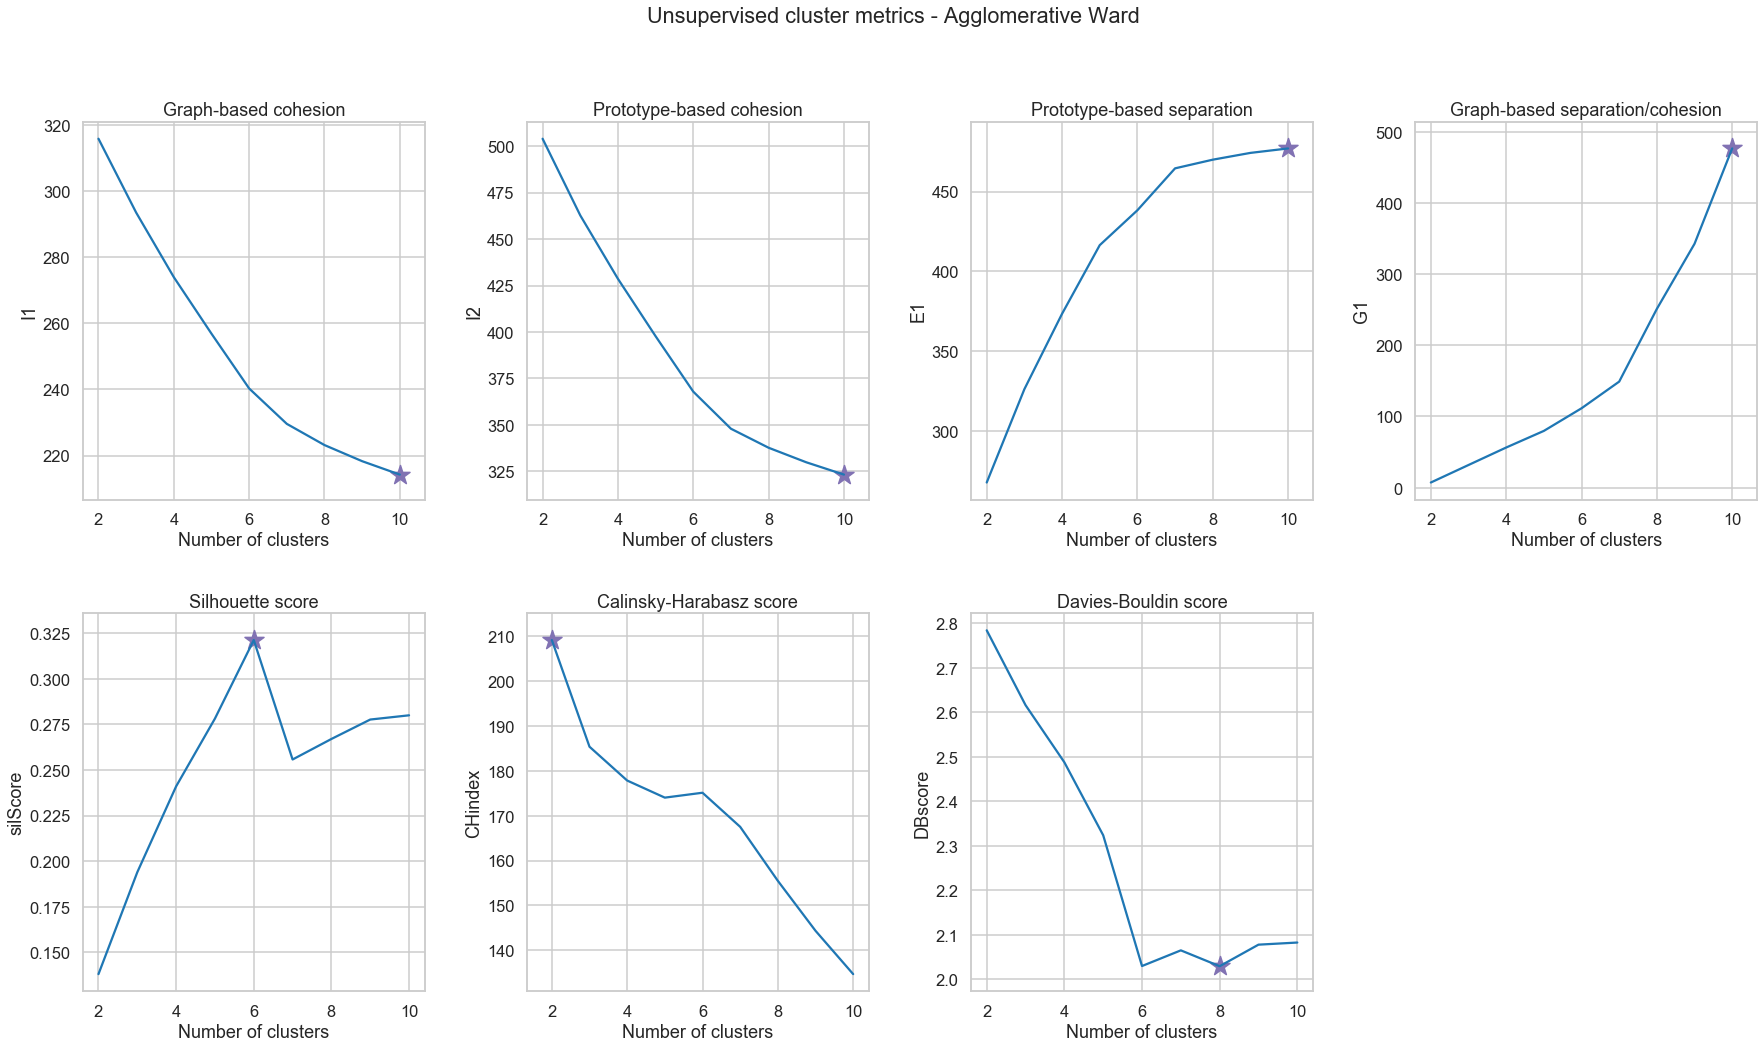

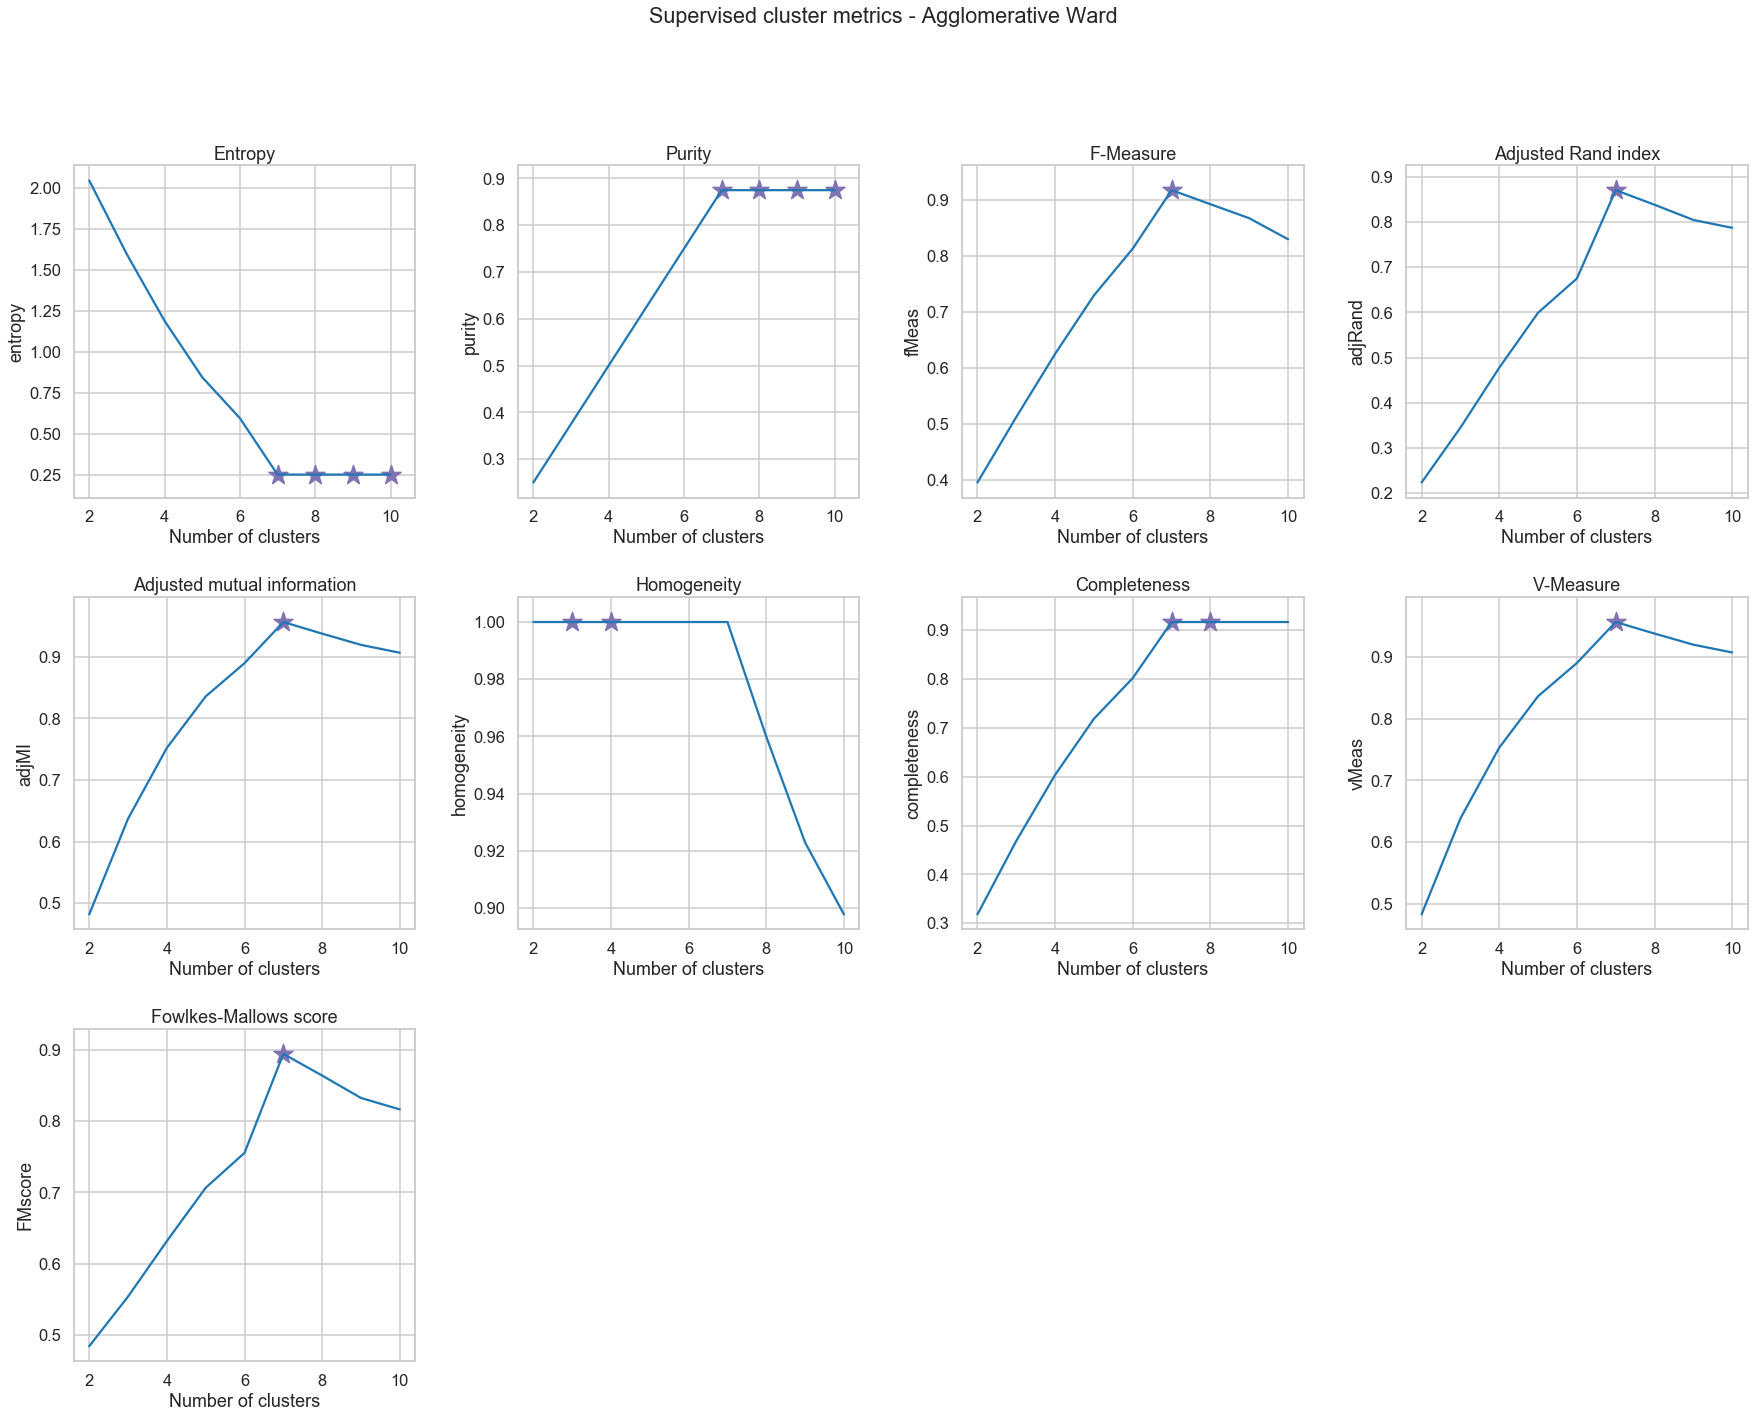

In [281]:
g = 0
# p = 0
# filt = (gestLabel == g) & (posLabel == p)
filt = (gestLabel == g)
X = hv[filt]

trialSubset = trialLabel[filt]
gestSubset = gestLabel[filt]
posSubset = posLabel[filt]

combs, superLabels = np.unique(np.column_stack((trialSubset,gestSubset,posSubset)),axis=0,return_inverse=True)

n_clusters, resU, resS, labels = test_num_clusts(X,agglom_ward,posSubset,2,10)
plot_unsuper_metrics(n_clusters,resU,'Agglomerative Ward')
plot_super_metrics(n_clusters,resS,'Agglomerative Ward')

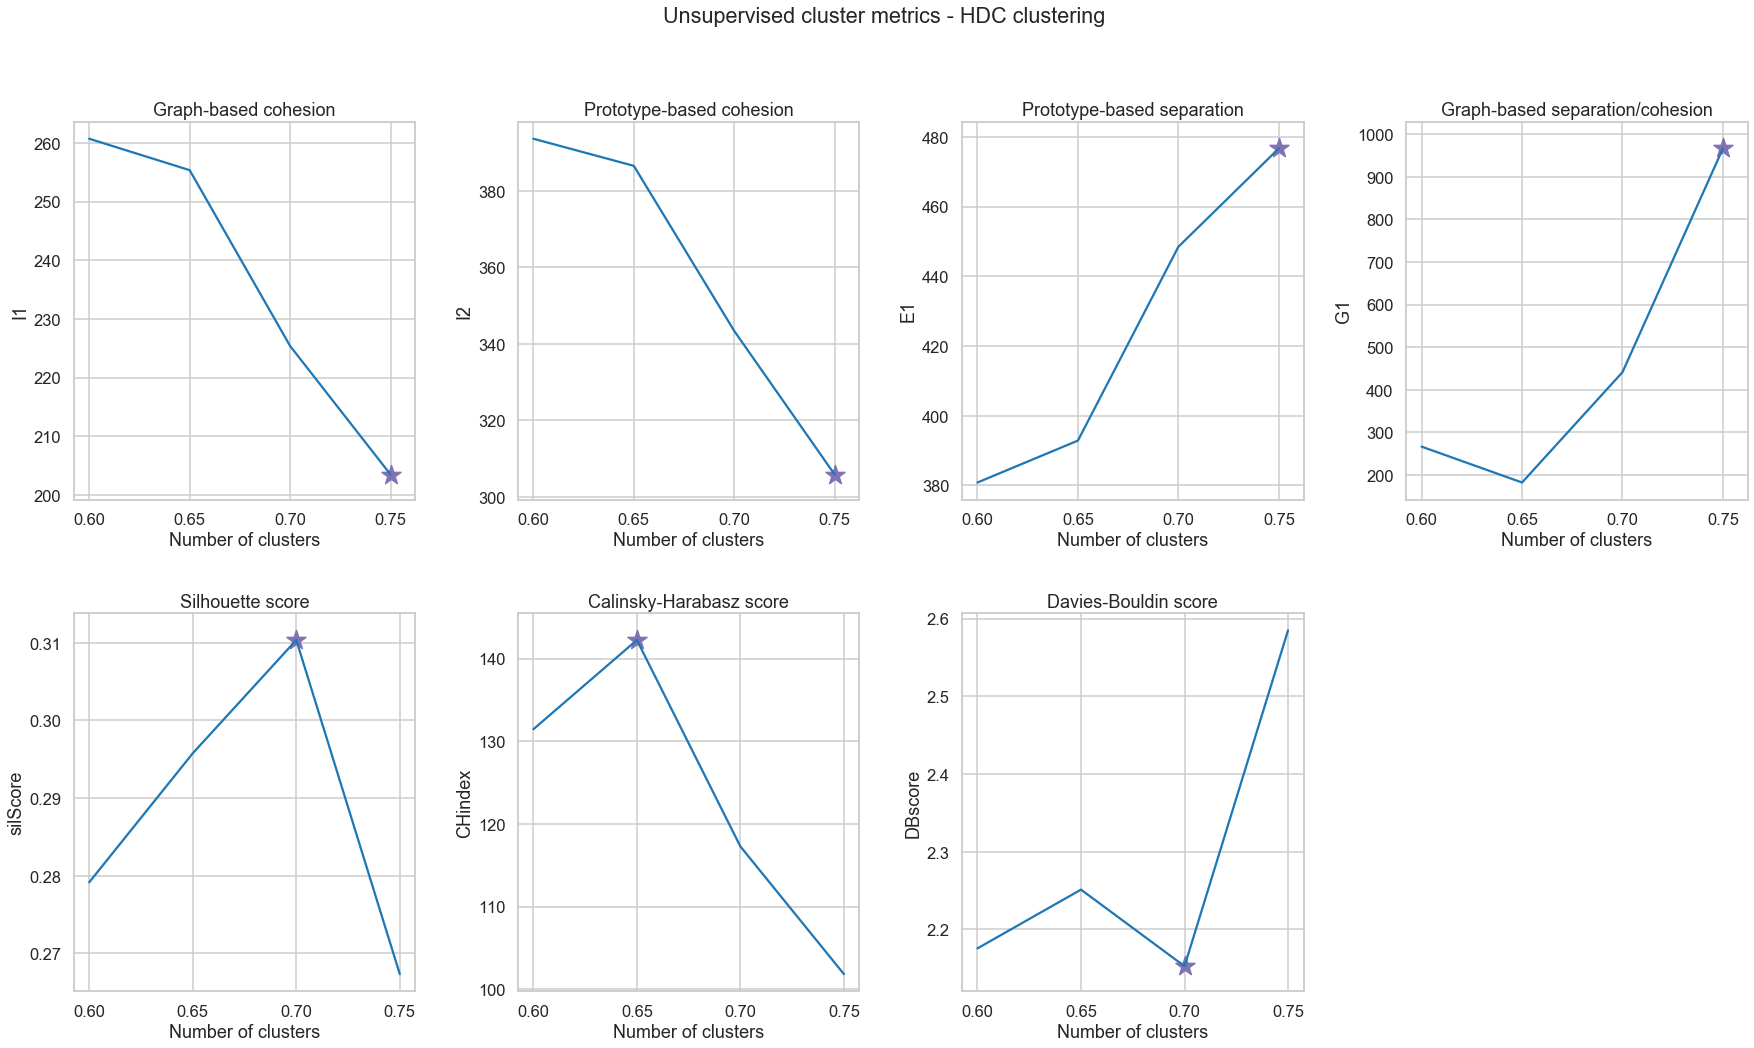

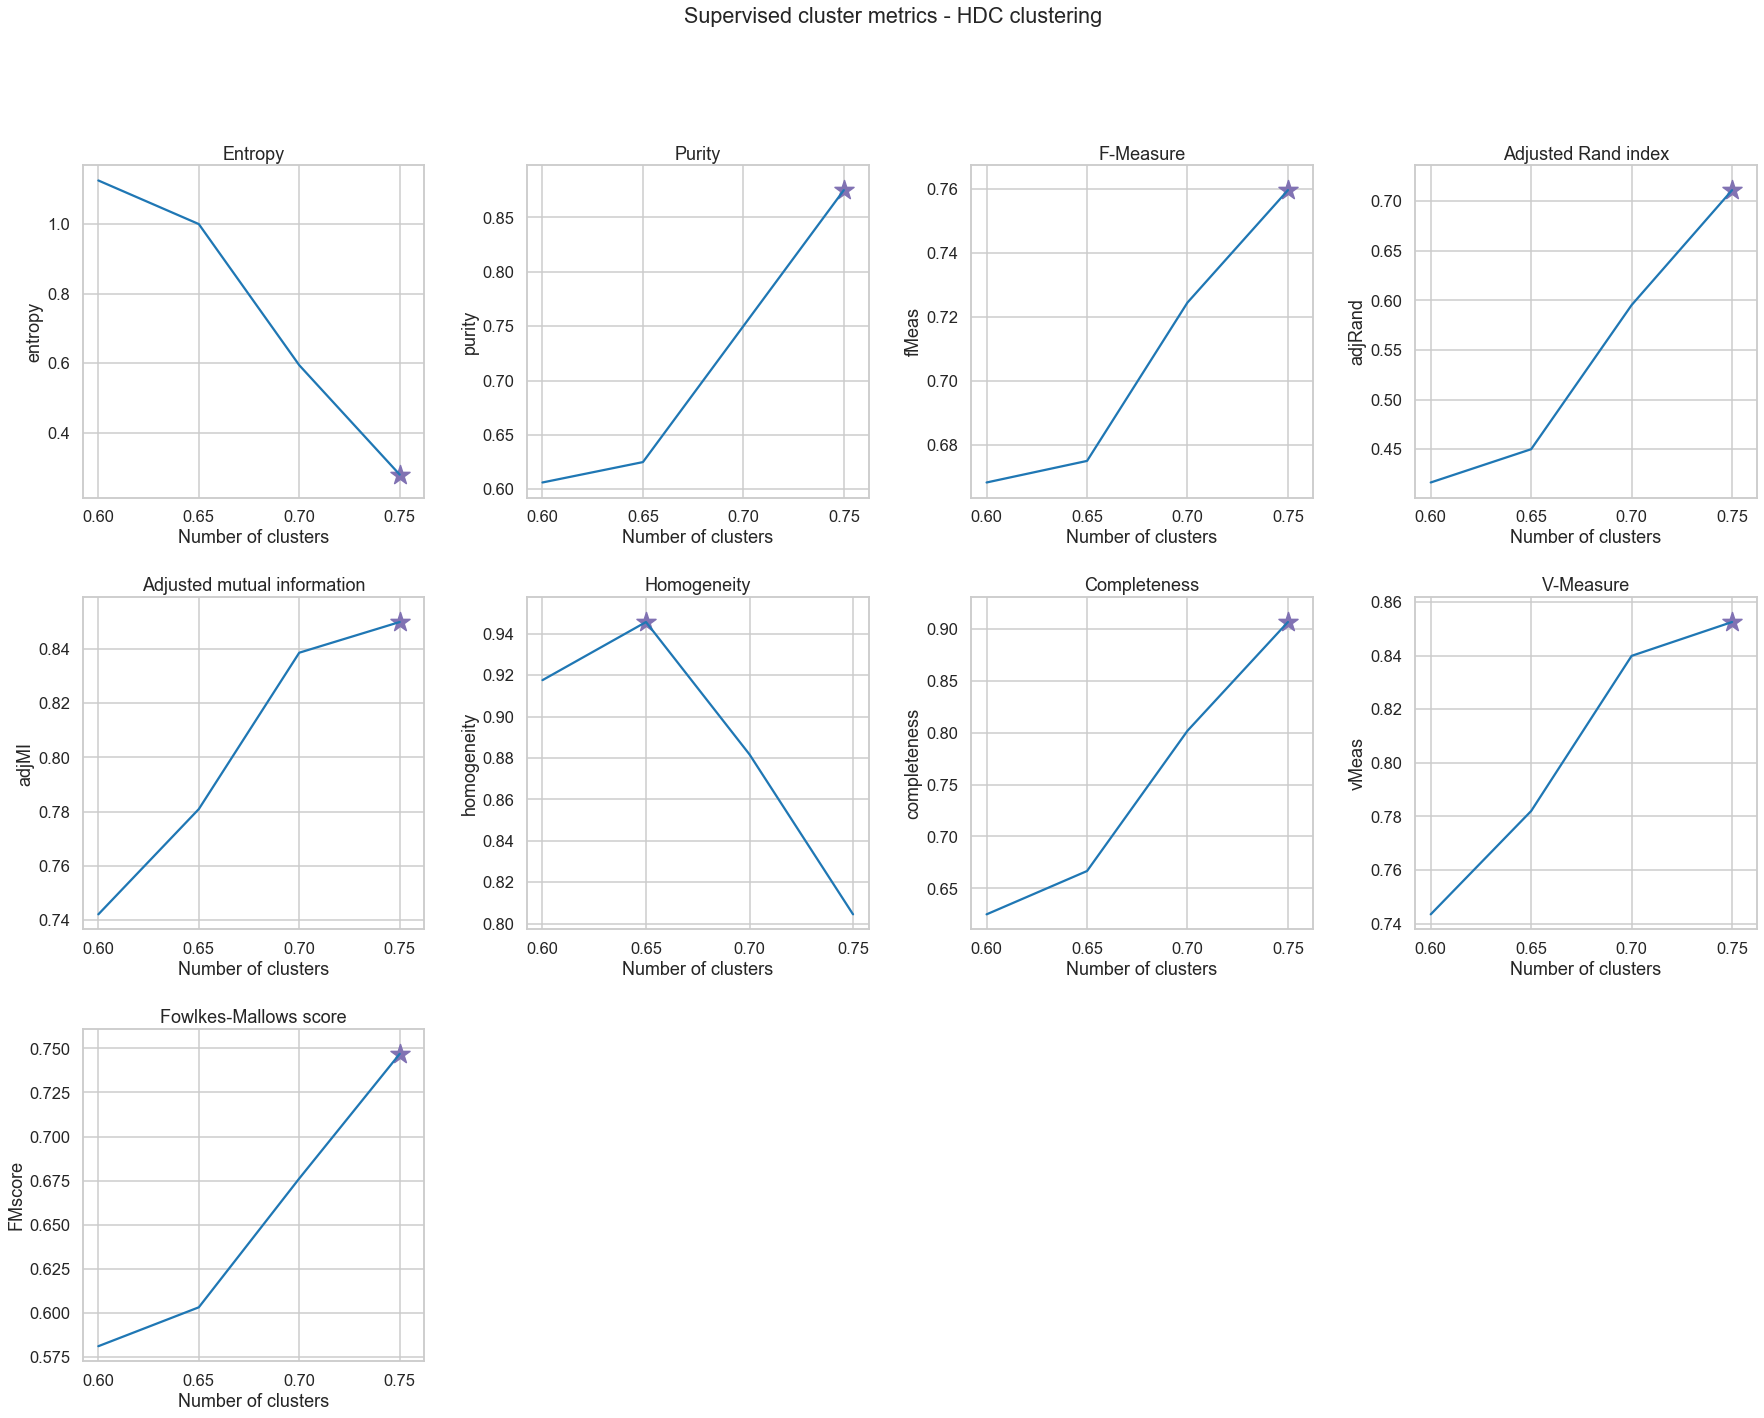

In [306]:
g = 0
# p = 0
# filt = (gestLabel == g) & (posLabel == p)
filt = (gestLabel == g)
X = hv[filt]

trialSubset = trialLabel[filt]
gestSubset = gestLabel[filt]
posSubset = posLabel[filt]

combs, superLabels = np.unique(np.column_stack((trialSubset,gestSubset,posSubset)),axis=0,return_inverse=True)

thresh, resU, resS, labels = test_hdc_thresh(X,hdc_clust,posSubset,0.55,0.75,0.05)
plot_unsuper_metrics(thresh,resU,'HDC clustering')
plot_super_metrics(thresh,resS,'HDC clustering')